## Project Phase 1 - Aviation Accident Data Integration
### Group 03:
- Tommaso Tragno - fc64699
- Manuel Cardoso - fc56274
- Chen Cheng - fc64872
- Cristian Tedesco - fc65149

#### Setup

In [121]:
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import os
import time
import seaborn as sns
import calendar
import py_stringmatching as sm
import re
from tqdm import tqdm
from pathlib import Path
import statsmodels.api as stm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chisquare
from rapidfuzz import distance

## 1. Data Loading

In [122]:
PATH = 'data_sources/'
FILTERED_PATH = 'filtered/'

NTSB_DATA = 'ntsb-us-2003-2023.json'
AIR_TRAFFIC_DATA = 'u-s-airline-traffic-data.csv'
AIRCRAFT_DATA = 'combined_aircraft_data.csv'
WEATHER_DATA = 'weather_results.json'

#### Load NTSB JSON Data

In [123]:
with open(PATH+NTSB_DATA, 'r', encoding='utf-8') as f:
    ntsb_raw_data = json.load(f)

# Each record is one accident/incident entry in a list
print(f'\n--- NTSB JSON loaded: {len(ntsb_raw_data)} total records found ---')

# Convert to a DataFrame (this will flatten top-level fields)
# For nested fields like 'Vehicles', we might do a separate flatten later
df_ntsb = pd.json_normalize(ntsb_raw_data, 
                            meta=[
                                'Oid','MKey','Closed','CompletionStatus','HasSafetyRec',
                                'HighestInjury','IsStudy','Mode','NtsbNumber',
                                'OriginalPublishedDate','MostRecentReportType','ProbableCause',
                                'City','Country','EventDate','State','Agency','BoardLaunch',
                                'BoardMeetingDate','DocketDate','EventType','Launch','ReportDate',
                                'ReportNum','ReportType','AirportId','AirportName','AnalysisNarrative',
                                'FactualNarrative','PrelimNarrative','FatalInjuryCount','MinorInjuryCount',
                                'SeriousInjuryCount','InvestigationClass','AccidentSiteCondition',
                                'Latitude','Longitude','DocketOriginalPublishDate'
                            ],
                            record_path=['Vehicles'],  # This flattens out the 'Vehicles' array
                            record_prefix='Vehicles.'
                           )

print('\n--- Flattened NTSB DataFrame (including Vehicles info): ---')

# print(df_ntsb.info())

# combines all injury counts to 1 column
df_ntsb['TotalInjuryCount'] = df_ntsb[['FatalInjuryCount', 'MinorInjuryCount', 'SeriousInjuryCount']].sum(axis=1)

# dropping unnecessary columns
df_ntsb.drop(columns=['AnalysisNarrative','FactualNarrative','PrelimNarrative','InvestigationClass','BoardLaunch'
                      ,'BoardMeetingDate','Launch','IsStudy','OriginalPublishedDate','DocketOriginalPublishDate'
                      ,'ReportType','ReportNum','ReportDate','MostRecentReportType','FatalInjuryCount','MinorInjuryCount'
                      ,'SeriousInjuryCount','DocketDate','Mode','HasSafetyRec','CompletionStatus','Closed'
                      ,'Vehicles.AircraftCategory','Vehicles.AmateurBuilt','Vehicles.EventID','Vehicles.AirMedical'
                      ,'Vehicles.AirMedicalType','Vehicles.flightScheduledType','Vehicles.flightServiceType'
                      ,'Vehicles.flightTerminalType','Vehicles.RegisteredOwner','Vehicles.RegulationFlightConductedUnder'
                      ,'Vehicles.RepGenFlag','Vehicles.RevenueSightseeing','Vehicles.SecondPilotPresent','Vehicles.Damage'
                      ,'AccidentSiteCondition'], inplace=True) 

# dropping NaT entries from EventDate
df_ntsb = df_ntsb.dropna(subset=['EventDate'])

# Type Conversion
df_ntsb['EventDate'] = pd.to_datetime(df_ntsb['EventDate']).dt.tz_localize(None)
df_ntsb['Vehicles.VehicleNumber'] = pd.to_numeric(df_ntsb['Vehicles.VehicleNumber'], errors='coerce').astype(int)
df_ntsb['MKey'] = pd.to_numeric(df_ntsb['MKey'], errors='coerce').astype(int)
df_ntsb['Vehicles.NumberOfEngines'] = pd.to_numeric(df_ntsb['Vehicles.NumberOfEngines'], errors='coerce').fillna(0).astype(int)
df_ntsb['Latitude'] = pd.to_numeric(df_ntsb['Latitude'], errors='coerce').astype(float)
df_ntsb['Longitude'] = pd.to_numeric(df_ntsb['Longitude'], errors='coerce').astype(float)
df_ntsb['TotalInjuryCount'] = pd.to_numeric(df_ntsb['TotalInjuryCount'], errors='coerce').astype(int)

categorical_cols = [
    'Vehicles.DamageLevel',
    'Vehicles.ExplosionType',
    'Vehicles.FireType',
    'HighestInjury',
    'EventType',
    'AccidentSiteCondition'
]

for col in categorical_cols:
    if col in df_ntsb.columns:
        df_ntsb[col] = df_ntsb[col].astype('category')

df_ntsb = df_ntsb.map(lambda x: x.lower() if isinstance(x, str) else x) # make all appropriate values lowercase

print(df_ntsb.info())

print('\n--- Saving filtered NTSB DataFrame... ---')
df_ntsb.to_pickle(PATH+'filtered/ntsb.pkl')


--- NTSB JSON loaded: 22992 total records found ---

--- Flattened NTSB DataFrame (including Vehicles info): ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23403 entries, 0 to 23402
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Vehicles.VehicleNumber        23403 non-null  int64         
 1   Vehicles.DamageLevel          23400 non-null  category      
 2   Vehicles.ExplosionType        21880 non-null  category      
 3   Vehicles.FireType             23321 non-null  category      
 4   Vehicles.SerialNumber         23283 non-null  object        
 5   Vehicles.Make                 23402 non-null  object        
 6   Vehicles.Model                23398 non-null  object        
 7   Vehicles.NumberOfEngines      23403 non-null  int64         
 8   Vehicles.RegistrationNumber   23397 non-null  object        
 9   Vehicles.FlightOperationType  21593 non-null  

#### Load Weather JSON Data
(after fetching the data from open-meteo API)

In [124]:
with open(PATH+WEATHER_DATA, 'r', encoding='utf-8') as f:
    weather_raw_data = json.load(f)

# Each record is one day weather entry in a list
print(f'\n--- Weather JSON loaded: {len(weather_raw_data)} total records found ---')

# weather_data is a dict, e.g.:
# {
#   "cen24la079_2023-12-31_41.610278_-90.588361": {
#       "time": [...],
#       "temperature_2m": [...],
#       ...
#   }
# }

# Flatten into a tabular structure
all_rows = []
num_skip = 0

for accident_id, subdict in weather_raw_data.items():
    # subdict is a dict with keys like "time", "temperature_2m", ...
    # Each key is an array of the same length (24 hours).
    times = subdict.get("time", None)
    if times is None:
        print(f'Skipping {accident_id}: no "time" found.')
        num_skip += 1
        continue
    num_hours = len(subdict["time"])
    for i in range(num_hours):
        row = {"AccidentID": accident_id}  # store the top-level key
        for param, values_array in subdict.items():
            # param: "time", "temperature_2m", ...
            row[param] = values_array[i]  # pick the ith hour’s value
        all_rows.append(row)

df_weather = pd.DataFrame(all_rows)

# The missing values exists because not all accident have position data
# this cause the api to return empty data.
print("Skipped {} records over {} accidents.".format(num_skip, len(weather_raw_data.items())))

# Type conversion
df_weather["time"] = pd.to_datetime(df_weather["time"], errors="coerce")

int_columns = [
    "relative_humidity_2m",
    "cloud_cover_low",
    "cloud_cover_mid",
    "cloud_cover_high",
    "wind_direction_10m",
    "wind_direction_100m",
    "weather_code"
]
float_columns = [
    "temperature_2m",
    "dew_point_2m",
    "pressure_msl",
    "surface_pressure",
    "precipitation",
    "rain",
    "snowfall",
    "wind_speed_10m",
    "wind_speed_100m",
    "wind_gusts_10m",
    "snow_depth"
]
for col in int_columns:
    df_weather[col] = pd.to_numeric(df_weather[col], errors="coerce").astype(int)
for col in float_columns:
    df_weather[col] = pd.to_numeric(df_weather[col], errors="coerce").astype(float)


print("\n--- Weather DataFrame sample ---")
print(df_weather.info())

print('\n--- Saving filtered Weather DataFrame... ---')
df_weather.to_pickle(PATH+'filtered/weather.pkl')


--- Weather JSON loaded: 20790 total records found ---
Skipping dca23wa432_2023-08-30_nan_nan: no "time" found.
Skipping cen23la030_2022-11-06_43511185.0_-1004241.0: no "time" found.
Skipping cen23la029_2022-11-02_390408.0_-953721.0: no "time" found.
Skipping cen23la020_2022-10-26_36940.21_-932048.49: no "time" found.
Skipping cen22la385_2022-08-10_43.12951_-85.67947: no "time" found.
Skipping cen22la310_2022-07-10_41.349_-894627.0: no "time" found.
Skipping cen22la180_2022-04-14_30.746616_-95.587956: no "time" found.
Skipping dca22wa057_2021-11-30_nan_nan: no "time" found.
Skipping dca21wa207_2021-08-14_nan_nan: no "time" found.
Skipping wpr21la163_2021-04-18_4603.0_-1041.12: no "time" found.
Skipping era18la213_2018-07-25_33.938888_-81.119445: no "time" found.
Skipping dca18wa177_2018-05-08_nan_nan: no "time" found.
Skipping cen16la033_2015-11-06_30.240554_-90.915275: no "time" found.
Skipping era16fa033_2015-11-06_27.2075_-80.842498: no "time" found.
Skipping era16fa032_2015-11-05_

#### Load Airline Traffic CSV Data

In [125]:
df_airline_traffic = pd.read_csv(PATH+AIR_TRAFFIC_DATA, encoding='utf-8')

print(f'\n--- Airline CSV loaded: {df_airline_traffic.shape[0]} rows, {df_airline_traffic.shape[1]} columns ---')

# dropping unnecessary columns
df_airline_traffic.drop(columns=['Dom_RPM','Int_RPM','RPM','Dom_ASM','Int_ASM','ASM'], inplace=True) 

# print(df_airline_traffic.info())

# Remove commas from all columns and then convert
df_airline_traffic = df_airline_traffic.replace(',', '', regex=True)

# Now convert each column to numeric. If everything converts well, no rows become NaN.
df_airline_traffic = df_airline_traffic.apply(pd.to_numeric, errors='coerce').astype(int)

print(df_airline_traffic.info())

print('\n--- Saving filtered Airline DataFrame... ---')
df_airline_traffic.to_pickle(PATH+'filtered/airline.pkl')


--- Airline CSV loaded: 249 rows, 17 columns ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Year     249 non-null    int64
 1   Month    249 non-null    int64
 2   Dom_Pax  249 non-null    int64
 3   Int_Pax  249 non-null    int64
 4   Pax      249 non-null    int64
 5   Dom_Flt  249 non-null    int64
 6   Int_Flt  249 non-null    int64
 7   Flt      249 non-null    int64
 8   Dom_LF   249 non-null    int64
 9   Int_LF   249 non-null    int64
 10  LF       249 non-null    int64
dtypes: int64(11)
memory usage: 21.5 KB
None

--- Saving filtered Airline DataFrame... ---


#### Load Aircraft ICAO CSV Data

In [126]:
df_aircraft = pd.read_csv(PATH+AIRCRAFT_DATA)

# === 1. Data Cleaning and Normalization ===
def clean_text(s):
    """ Normalizzazione del testo: rimozione di caratteri speciali, lowercase e spazi extra. """
    return re.sub(r'\W+', ' ', str(s)).lower().strip()

# applica la normalizzazione
for col in ['model_no', 'manufacturer_code']:
    df_aircraft[col] = df_aircraft[col].apply(clean_text)

# rimuovi le righe senza model_no
df_aircraft.dropna(subset=['model_no'], inplace=True)

# === 2. Type conversion ===
# drop model_version (100% missing)
if 'model_version' in df_aircraft.columns:
    df_aircraft.drop(columns=['model_version'], inplace=True)

# cast alle categorie e numerici
df_aircraft = df_aircraft.astype({
    'manufacturer_code': 'object',
    'model_name'       : 'object',
    'model_no'         : 'object',
    'engine_count'     : 'int64',
    'engine_type'      : 'category',
    'aircraft_desc'    : 'object',
    'description'      : 'object',
    'wtc'              : 'object',
    'tdesig'           : 'object',
    'wtg'              : 'object'
})

print(df_aircraft.info())

print('\n--- Saving filtered NTSB DataFrame... ---')
df_aircraft.to_pickle(PATH+'filtered/aircraft_ICAO.pkl')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2270 entries, 0 to 2269
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   manufacturer_code  2270 non-null   object  
 1   model_no           2270 non-null   object  
 2   model_name         1543 non-null   object  
 3   engine_count       2270 non-null   int64   
 4   engine_type        2270 non-null   category
 5   aircraft_desc      2270 non-null   object  
 6   description        2270 non-null   object  
 7   wtc                2270 non-null   object  
 8   tdesig             2270 non-null   object  
 9   wtg                2267 non-null   object  
dtypes: category(1), int64(1), object(8)
memory usage: 162.2+ KB
None

--- Saving filtered NTSB DataFrame... ---


### 2. Data Profiling

In [127]:
def profile_dataframe(df, name='DataFrame'):
    print(f'\n=== Profiling {name} ===')
    print(f'Total Rows: {len(df)}')
    print(f'Total Columns: {len(df.columns)}\n')
    
    profile_results = []

    for col in df.columns:
        series = df[col]
        col_dtype = series.dtype
        
        # Basic counts
        total_count = len(series)
        missing_vals = series.isna().sum()
        non_null_count = total_count - missing_vals
        missing_perc = (missing_vals / total_count) * 100
        unique_vals = series.nunique(dropna=False)
        
        # Mode & frequency
        try:
            modes = series.mode(dropna=True)
            mode_val = modes.iloc[0] if len(modes) > 0 else np.nan
            mode_freq = (series == mode_val).sum(skipna=True)
        except:
            mode_val, mode_freq = np.nan, np.nan
        
        # Initialize placeholders
        mean_ = np.nan
        min_  = np.nan
        q25   = np.nan
        q50   = np.nan
        q75   = np.nan
        max_  = np.nan
        std_  = np.nan  # only for numeric columns

        # Numeric columns
        if pd.api.types.is_numeric_dtype(series):
            mean_ = series.mean(skipna=True)
            min_  = series.min(skipna=True)
            q25   = series.quantile(0.25)
            q50   = series.quantile(0.50)
            q75   = series.quantile(0.75)
            max_  = series.max(skipna=True)
            std_  = series.std(skipna=True)

        # Datetime columns
        elif pd.api.types.is_datetime64_any_dtype(series):
            # We can compute mean & quartiles by time. 
            # .quantile() and .mean() are valid for datetime in pandas
            # They return a Timestamp for mean, 
            # and Timestamps for quantiles
            if non_null_count > 0:
                mean_ = series.mean(skipna=True)
                min_  = series.min(skipna=True)
                q25   = series.quantile(0.25)
                q50   = series.quantile(0.50)
                q75   = series.quantile(0.75)
                max_  = series.max(skipna=True)
            # We skip std_ for datetime.

        # Categorical/object columns 
        # do not get numeric stats (we keep them as NaN).

        profile_results.append((
            col,
            str(col_dtype),
            total_count,
            non_null_count,
            missing_vals,
            round(missing_perc, 2),
            unique_vals,
            mode_val,
            mode_freq,
            mean_,
            min_,
            q25,
            q50,
            q75,
            max_,
            std_
        ))

    columns = [
        'Column', 'DataType', 'TotalCount', 'NonNullCount', 'NumMissing',
        'MissingPerc', 'Cardinality', 'Mode', 'ModeFreq',
        'Mean', 'Min', 'Q25', 'Q50', 'Q75', 'Max', 'Std'
    ]

    prof_df = pd.DataFrame(profile_results, columns=columns)
    
    return prof_df

#### NTSB Data Profile

In [128]:
ntsb_profile = profile_dataframe(df_ntsb, name='NTSB Data')
display(HTML(ntsb_profile.to_html()))
ntsb_profile.to_csv(PATH+'profiling/ntsb_profile.csv', index=False)


=== Profiling NTSB Data ===
Total Rows: 23403
Total Columns: 27



,Column,DataType,TotalCount,NonNullCount,NumMissing,MissingPerc,Cardinality,Mode,ModeFreq,Mean,Min,Q25,Q50,Q75,Max,Std
0,Vehicles.VehicleNumber,int64,23403,23403,0,0.00,3,1,22986,1.018117,1,1.0,1.0,1.0,3,0.135603
1,Vehicles.DamageLevel,category,23403,23400,3,0.01,6,substantial,19718,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Vehicles.ExplosionType,category,23403,21880,1523,6.51,6,none,21306,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Vehicles.FireType,category,23403,23321,82,0.35,7,none,20993,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Vehicles.SerialNumber,object,23403,23283,120,0.51,21514,001,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Vehicles.Make,object,23403,23402,1,0.00,1098,cessna,8191,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Vehicles.Model,object,23403,23398,5,0.02,3362,172,762,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Vehicles.NumberOfEngines,int64,23403,23403,0,0.00,5,1,19416,1.13823,0,1.0,1.0,1.0,4,0.422117
8,Vehicles.RegistrationNumber,object,23403,23397,6,0.03,22386,unreg,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Vehicles.FlightOperationType,object,23403,21593,1810,7.73,22,pers,14516,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Insights from the data profile results:

- there are some `null` values for Latitude and Longitude --> we keep like this, but they should be handled during the API calls to open-meteo
- there are less unique `NtsbNumber` than rows --> for incident where more than one aircraft is involved, the rows are duplicated with different values for Vehicles characteristic, and same value for incident data (look at the following example)

In [129]:
df_ntsb.loc[df_ntsb['NtsbNumber']=='ops24la011']

,Vehicles.VehicleNumber,Vehicles.DamageLevel,Vehicles.ExplosionType,Vehicles.FireType,Vehicles.SerialNumber,Vehicles.Make,Vehicles.Model,Vehicles.NumberOfEngines,Vehicles.RegistrationNumber,Vehicles.FlightOperationType,...,Country,EventDate,State,Agency,EventType,AirportId,AirportName,Latitude,Longitude,TotalInjuryCount
39,1,none,none,none,c0218,diamond aircraft ind inc,da20-c1,1,n857pa,None,...,usa,2023-12-09 13:06:00,nv,ntsb,occ,vgt,north las vegas,36.211268,-115.19968,0
40,2,none,none,none,1955,robinson helicopter,r44,1,n744af,None,...,usa,2023-12-09 13:06:00,nv,ntsb,occ,vgt,north las vegas,36.211268,-115.19968,0


#### Weather Data Profile

In [130]:
weather_profile = profile_dataframe(df_weather, name='Weather Data')
display(HTML(weather_profile.to_html()))
weather_profile.to_csv(PATH+'profiling/weather_profile.csv', index=False)


=== Profiling Weather Data ===
Total Rows: 491592
Total Columns: 21



,Column,DataType,TotalCount,NonNullCount,NumMissing,MissingPerc,Cardinality,Mode,ModeFreq,Mean,Min,Q25,Q50,Q75,Max,Std
0,AccidentID,object,491592,491592,0,0.00,20483,anc04ca085_2004-08-04_65.697502_-156.351104,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,time,datetime64[ns],491592,491592,0,0.00,155280,2011-06-18 00:00:00,14,2013-08-13 21:55:37.157643008,2004-07-24 00:00:00,2008-08-17 17:45:00,2013-03-11 02:30:00,2018-06-19 07:00:00,2023-12-31 23:00:00,NaN
2,temperature_2m,float64,491592,491592,0,0.00,806,23.5,1994,15.903267,-36.0,9.1,17.3,23.9,46.2,10.640686
3,relative_humidity_2m,int64,491592,491592,0,0.00,100,84,8307,64.547621,1,49.0,68.0,83.0,100,22.852449
4,dew_point_2m,float64,491592,491592,0,0.00,659,11.4,1969,7.872516,-39.5,0.9,8.9,15.9,27.6,10.155472
5,pressure_msl,float64,491592,491592,0,0.00,820,1015.6,3616,1015.685346,962.4,1011.8,1015.6,1019.7,1053.2,6.923077
6,surface_pressure,float64,491592,491592,0,0.00,3907,1014.0,1154,967.432852,602.2,958.7,990.6,1008.8,1041.5,62.377769
7,precipitation,float64,491592,491592,0,0.00,163,0.0,442059,0.074952,0.0,0.0,0.0,0.0,37.0,0.456493
8,rain,float64,491592,491592,0,0.00,163,0.0,446844,0.069873,0.0,0.0,0.0,0.0,37.0,0.450826
9,snowfall,float64,491592,491592,0,0.00,44,0.0,484116,0.003738,0.0,0.0,0.0,0.0,3.78,0.048473


#### Air Traffic Data Profile

In [131]:
airline_profile = profile_dataframe(df_airline_traffic, name='Airline Data')
display(HTML(airline_profile.to_html()))
airline_profile.to_csv(PATH+'profiling/airline_profile.csv', index=False)


=== Profiling Airline Data ===
Total Rows: 249
Total Columns: 11



,Column,DataType,TotalCount,NonNullCount,NumMissing,MissingPerc,Cardinality,Mode,ModeFreq,Mean,Min,Q25,Q50,Q75,Max,Std
0,Year,int64,249,249,0,0.0,21,2003,12,2.012880e+03,2003,2008.0,2013.0,2018.0,2023,6.002817e+00
1,Month,int64,249,249,0,0.0,12,1,21,6.445783e+00,1,3.0,6.0,9.0,12,3.442803e+00
2,Dom_Pax,int64,249,249,0,0.0,249,2877290,1,5.520971e+07,2877290,50982170.0,56200104.0,60892131.0,75378157,1.044055e+07
3,Int_Pax,int64,249,249,0,0.0,249,136609,1,7.392209e+06,136609,6395022.0,7419187.0,8567847.0,12432615,2.020273e+06
4,Pax,int64,249,249,0,0.0,249,3013899,1,6.260192e+07,3013899,57664576.0,63899130.0,69447429.0,87810772,1.229211e+07
5,Dom_Flt,int64,249,249,0,0.0,249,217262,1,7.067507e+05,217262,662000.0,709933.0,781804.0,890938,1.070550e+05
6,Int_Flt,int64,249,249,0,0.0,248,63469,2,6.473617e+04,4996,61615.0,66557.0,71924.0,82681,1.212962e+04
7,Flt,int64,249,249,0,0.0,249,222280,1,7.714869e+05,222280,727898.0,779011.0,848650.0,964102,1.156867e+05
8,Dom_LF,int64,249,249,0,0.0,36,85,30,7.943775e+01,13,77.0,82.0,85.0,89,8.858494e+00
9,Int_LF,int64,249,249,0,0.0,41,79,23,7.681928e+01,23,76.0,79.0,82.0,89,1.087741e+01


#### Aircraft ICAO Data Profile

In [132]:
aircraft_profile = profile_dataframe(df_aircraft, name='Aircraft Data')
display(HTML(aircraft_profile.to_html()))
aircraft_profile.to_csv(PATH+'profiling/aircraft_profile.csv', index=False)


=== Profiling Aircraft Data ===
Total Rows: 2270
Total Columns: 10



,Column,DataType,TotalCount,NonNullCount,NumMissing,MissingPerc,Cardinality,Mode,ModeFreq,Mean,Min,Q25,Q50,Q75,Max,Std
0,manufacturer_code,object,2270,2270,0,0.00,35,cessna,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,model_no,object,2270,2270,0,0.00,1254,nan,659,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,model_name,object,2270,1543,727,32.03,623,Huron,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,engine_count,int64,2270,2270,0,0.00,5,1,1152,1.580617,1.0,1.0,1.0,2.0,8.0,0.721375
4,engine_type,category,2270,2270,0,0.00,4,Piston,1242,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,aircraft_desc,object,2270,2270,0,0.00,4,LandPlane,2171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,description,object,2270,2270,0,0.00,18,L1P,970,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,wtc,object,2270,2270,0,0.00,5,L,1496,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,tdesig,object,2270,2270,0,0.00,526,P28A,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,wtg,object,2270,2267,3,0.13,9,G,1775,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Charts

    Month       Flt Month_Name
0       1  15719309        Jan
1       2  14510406        Feb
2       3  16693640        Mar
3       4  15822706        Apr
4       5  16417155        May
5       6  16606399        Jun
6       7  17434916        Jul
7       8  17361760        Aug
8       9  15770979        Sep
9      10  15622573        Oct
10     11  14910368        Nov
11     12  15230023        Dec


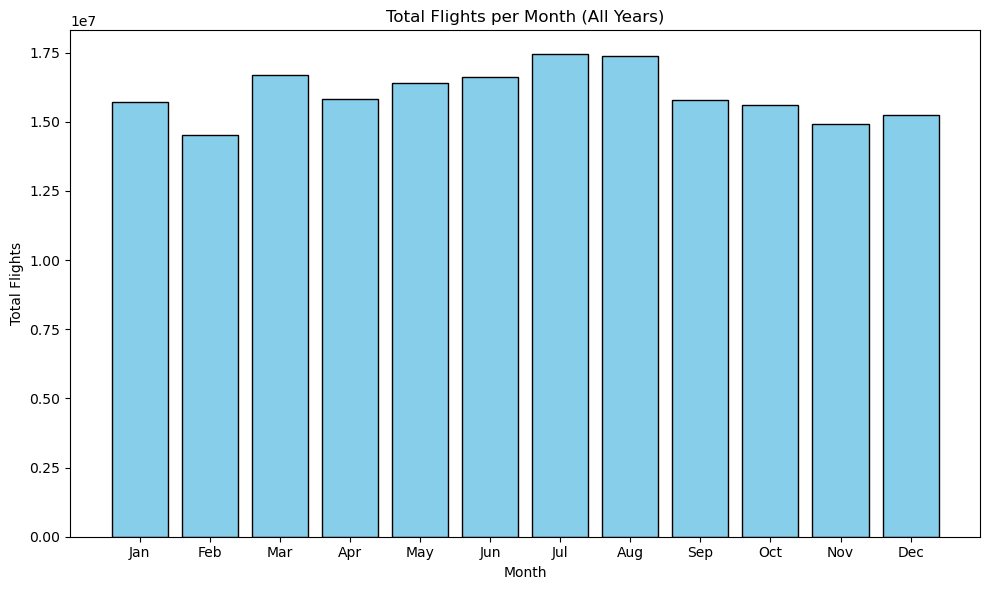

/tmp/ipykernel_335333/2293526212.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_airline, x='Month_Name', y='Flt', order=month_order, palette='pastel')


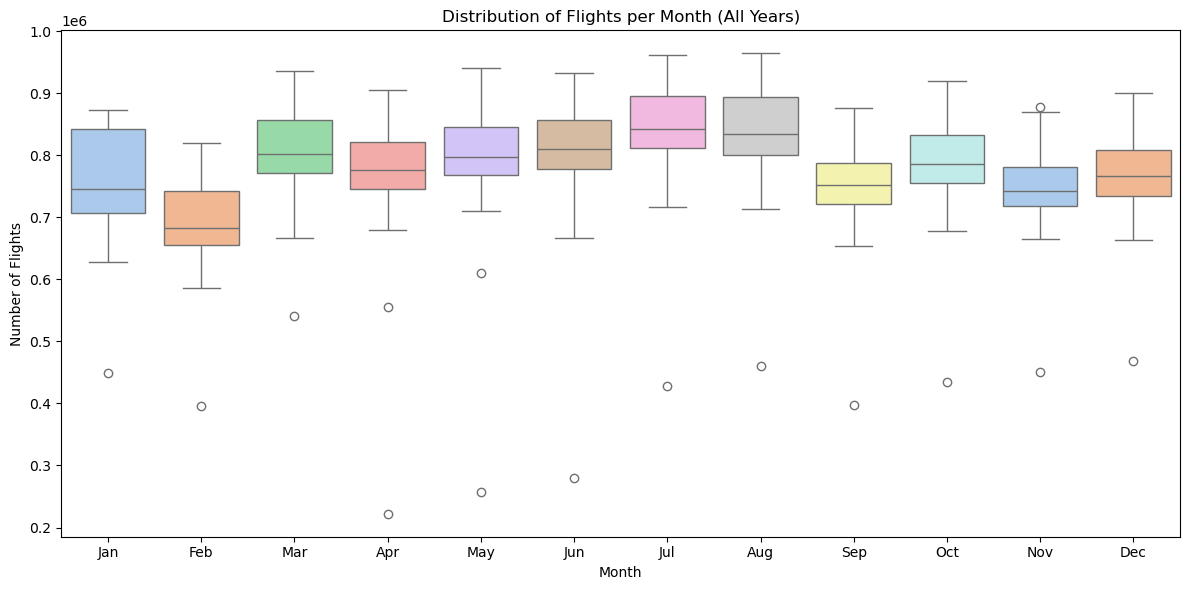

In [133]:
df_airline = pd.read_pickle(PATH + FILTERED_PATH + 'airline.pkl')

# Group by 'Month' and sum 'Flt'
monthly_flt_sum = df_airline.groupby('Month')['Flt'].sum().reset_index()

# Sort by month to be sure
monthly_flt_sum = monthly_flt_sum.sort_values('Month')

# Map month numbers to names (Jan, Feb, ...)
month_names = [calendar.month_abbr[m] for m in monthly_flt_sum['Month']]
monthly_flt_sum['Month_Name'] = month_names

# Display result
print(monthly_flt_sum)

# Histogram
# Plot
plt.figure(figsize=(10, 6))
plt.bar(monthly_flt_sum['Month_Name'], monthly_flt_sum['Flt'], color='skyblue', edgecolor='black')

# Labels and title
plt.title('Total Flights per Month (All Years)')
plt.xlabel('Month')
plt.ylabel('Total Flights')

plt.tight_layout()
plt.show()

# Box Plot
# Map numeric month to abbreviation
df_airline['Month_Name'] = df_airline['Month'].apply(lambda x: calendar.month_abbr[x])

# Optional: Order months correctly
month_order = list(calendar.month_abbr)[1:]  # ['Jan', 'Feb', ..., 'Dec']

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_airline, x='Month_Name', y='Flt', order=month_order, palette='pastel')

# Labels and title
plt.title('Distribution of Flights per Month (All Years)')
plt.xlabel('Month')
plt.ylabel('Number of Flights')

plt.tight_layout()
plt.show()

## Blocking strategy

In [134]:

# === 1. Data Loading ===
# Caricamento dei dataset
df_aircraft = pd.read_csv('data_sources/combined_aircraft_data.csv')
df_ntsb = pd.read_pickle(PATH + FILTERED_PATH + 'ntsb.pkl')

# Selezione delle colonne necessarie
df_ntsb_model = df_ntsb[['NtsbNumber', 'EventDate', 'Vehicles.SerialNumber',
                         'Vehicles.RegistrationNumber', 'Vehicles.Make', 'Vehicles.Model']].copy()

# === 2. Data Cleaning and Normalization ===
def clean_text(s):
    """ Normalizzazione del testo: rimozione di caratteri speciali, lowercase e spazi extra. """
    return re.sub(r'\W+', ' ', str(s)).lower().strip()

# Pulizia dei dati
df_ntsb_model['Vehicles.Model'] = df_ntsb_model['Vehicles.Model'].apply(clean_text)
df_ntsb_model['Vehicles.Make'] = df_ntsb_model['Vehicles.Make'].apply(clean_text)

df_aircraft['model_no'] = df_aircraft['model_no'].apply(clean_text)
df_aircraft['manufacturer_code'] = df_aircraft['manufacturer_code'].apply(clean_text)

df_ntsb_model.dropna(subset=['Vehicles.Model'], inplace=True)
df_aircraft.dropna(subset=['model_no'], inplace=True)

# === 3. Similarity Setup ===
jw = sm.JaroWinkler()
lev = sm.Levenshtein()
jac = sm.Jaccard()  

# === 4. Precomputation degli n-gram ===
def generate_qgrams(model):
    """ Genera un insieme di trigrammi (q-grams di lunghezza 3) per una stringa data. """
    qgrams = [model[i:i+3] for i in range(len(model) - 2)]
    return set(qgrams)

# === 5. Matching with Optimized Loop ===
matches = []
matched_set = set()  # Set per controllare i duplicati di NtsbNumber + SerialNumber
serial_set = set()   # Set per controllare i duplicati di SerialNumber

for i, ntsb_row in df_ntsb_model.iterrows():
    model_ntsb = ntsb_row['Vehicles.Model']
    make_ntsb = ntsb_row['Vehicles.Make']
    grams_ntsb = generate_qgrams(model_ntsb)

    # 🔎 **Filtro preliminare basato sul Make (flessibile)**
    filtered_aircraft = df_aircraft[
        df_aircraft['manufacturer_code'].apply(lambda x: make_ntsb in x or x in make_ntsb or jw.get_sim_score(x, make_ntsb) > 0.85)
    ]
    
    # Se non ci sono candidati, passa al prossimo ciclo
    if filtered_aircraft.empty:
        continue

    # Precomputa gli n-gram per i candidati
    aircraft_grams = {index: generate_qgrams(model) for index, model in enumerate(filtered_aircraft['model_no'])}

    # 🔎 **Filtro preliminare basato sugli n-grammi**
    candidate_matches = []
    for idx, grams_aircraft in aircraft_grams.items():
        if len(grams_ntsb & grams_aircraft) >= 2:
            candidate_matches.append(filtered_aircraft.index[idx])

    if not candidate_matches:
        continue  # Nessun match possibile, passo al successivo

    # 🔎 **Controllo diretto:** se esiste un match esatto tra i candidati
    direct_match = df_aircraft.loc[candidate_matches]
    direct_match = direct_match[direct_match['model_no'] == model_ntsb]

    if not direct_match.empty:
        for _, row in direct_match.iterrows():
            match_id = f"{ntsb_row['NtsbNumber']}_{ntsb_row['Vehicles.SerialNumber']}_{row['model_no']}"
            if match_id not in matched_set and ntsb_row['Vehicles.SerialNumber'] not in serial_set:
                matches.append({
                    'NtsbNumber': ntsb_row['NtsbNumber'],
                    'EventDate': ntsb_row['EventDate'],
                    'Vehicles.SerialNumber': ntsb_row['Vehicles.SerialNumber'],
                    'Vehicles.RegistrationNumber': ntsb_row['Vehicles.RegistrationNumber'],
                    'Vehicles.Make': ntsb_row['Vehicles.Make'],
                    'Vehicles.Model': model_ntsb,
                    'Matched_Aircraft_Model': row['model_no'],
                    'engine_count': row['engine_count'],
                    'engine_type': row['engine_type'],
                    'JW_Score': 1.0,
                    'LEV_Score': 1.0,
                    'Jac_Score': 1.0,
                    'SimilarityScore': 1.0
                })
                matched_set.add(match_id)
                serial_set.add(ntsb_row['Vehicles.SerialNumber'])

        continue  # Salta il loop di matching

    # 🔎 **Controllo di Variante Generico**
    for idx in candidate_matches:
        model_aircraft = df_aircraft.loc[idx, 'model_no']

        # Numeric Filter: numbers must match if present
        nums_ntsb = re.findall(r'\d+', model_ntsb)
        nums_aircraft = re.findall(r'\d+', model_aircraft)

        if nums_ntsb and nums_aircraft and nums_ntsb != nums_aircraft:
            continue

        # Computing the Three Similarity Scores
        jw_score = jw.get_sim_score(model_ntsb, model_aircraft)
        lev_score = lev.get_sim_score(model_ntsb, model_aircraft)
        jac_score = jac.get_sim_score(list(grams_ntsb), list(generate_qgrams(model_aircraft)))

        # Linear Rule
        final_score = 0.4 * jw_score + 0.3 * lev_score + 0.3 * jac_score

        # Controllo duplicati
        match_id = f"{ntsb_row['NtsbNumber']}_{ntsb_row['Vehicles.SerialNumber']}_{model_aircraft}"
        if final_score > 0.75 and match_id not in matched_set and ntsb_row['Vehicles.SerialNumber'] not in serial_set:
            matches.append({
                'NtsbNumber': ntsb_row['NtsbNumber'],
                'EventDate': ntsb_row['EventDate'],
                'Vehicles.SerialNumber': ntsb_row['Vehicles.SerialNumber'],
                'Vehicles.RegistrationNumber': ntsb_row['Vehicles.RegistrationNumber'],
                'Vehicles.Make': ntsb_row['Vehicles.Make'],
                'Vehicles.Model': model_ntsb,
                'Matched_Aircraft_Model': model_aircraft,
                'engine_count': df_aircraft.loc[idx, 'engine_count'],
                'engine_type': df_aircraft.loc[idx, 'engine_type'],
                'JW_Score': round(jw_score, 3),
                'LEV_Score': round(lev_score, 3),
                'Jac_Score': round(jac_score, 3),
                'SimilarityScore': round(final_score, 4)
            })
            matched_set.add(match_id)
            serial_set.add(ntsb_row['Vehicles.SerialNumber'])

# === 6. Final Output ===
if not matches:
    print("No matches found with the current rules.")
else:
    df_matches = pd.DataFrame(matches)
    print(f"Matches Found: {len(df_matches)}")
    print("Columns:", df_matches.columns.tolist())
    df_matches = df_matches.sort_values(by='SimilarityScore', ascending=False)
    display(df_matches.head(25))
    df_matches.to_csv('data_sources/binding/matched_results.csv', index=False)

Matches Found: 4963
Columns: ['NtsbNumber', 'EventDate', 'Vehicles.SerialNumber', 'Vehicles.RegistrationNumber', 'Vehicles.Make', 'Vehicles.Model', 'Matched_Aircraft_Model', 'engine_count', 'engine_type', 'JW_Score', 'LEV_Score', 'Jac_Score', 'SimilarityScore']


,NtsbNumber,EventDate,Vehicles.SerialNumber,Vehicles.RegistrationNumber,Vehicles.Make,Vehicles.Model,Matched_Aircraft_Model,engine_count,engine_type,JW_Score,LEV_Score,Jac_Score,SimilarityScore
4961,nyc03fa035,2003-01-06 13:48:00,633,n16571,embraer,erj 145lr,erj 145lr,2,Jet,1.0,1.0,1.0,1.0
4921,den03la048,2003-03-11 13:00:00,n78559,n78559,piper,pa 12,pa 12,1,Piston,1.0,1.0,1.0,1.0
4923,den03fa045,2003-03-07 20:18:00,4697119,n522rf,piper,pa 46 500tp,pa 46 500tp,1,Turboprop/Turboshaft,1.0,1.0,1.0,1.0
4924,den03la046,2003-03-07 15:05:00,28-2336,n8205w,piper,pa 28 180,pa 28 180,1,Piston,1.0,1.0,1.0,1.0
4926,mia03la073,2003-03-05 15:20:00,28-8016269,n81549,piper,pa 28 161,pa 28 161,1,Piston,1.0,1.0,1.0,1.0
4927,atl03la053,2003-03-04 18:35:00,32r-7780329,n4135q,piper,pa 32r 300,pa 32r 300,1,Piston,1.0,1.0,1.0,1.0
4928,mia03fa071,2003-03-03 20:29:00,28r-7803222,n6369c,piper,pa 28r 201t,pa 28r 201t,1,Piston,1.0,1.0,1.0,1.0
4913,chi03la089,2003-03-22 15:57:00,574,n1814g,champion,7eca,7eca,1,Piston,1.0,1.0,1.0,1.0
4915,atl03la063,2003-03-16 16:30:00,a152097,n762js,cessna,a152,a152,1,Piston,1.0,1.0,1.0,1.0
4918,ftw03la113,2003-03-14 18:30:00,28-4562,n5264l,piper,pa 28 180,pa 28 180,1,Piston,1.0,1.0,1.0,1.0


## Data Fusion Strategy

In [135]:
df = pd.read_pickle("data_sources/filtered/ntsb.pkl")
ntsb_og = df.copy()
ntsb_copied = df.copy()
ntsb_copied = ntsb_copied.rename(columns=
    {"EventDate": "Date", 
    "NtsbNumber": "ID", 
    "State": "Location"}) # for schema matching 

seed = 10
np.random.seed(seed)

n = len(ntsb_copied)

# select 60% indices for later use
n_forty = int(np.floor(0.6 * n))
random_indices = np.random.choice(ntsb_copied.index, n_forty, replace=False)
print(f"random_indices count (60%): {len(random_indices)}")  # Should be ~0.6 * n

# select half of these indices to assign NaN in 'State'
n_missing = int(np.floor(0.5 * n_forty))
missing_indices = np.random.choice(random_indices, n_missing, replace=False)

# assign NaN only to these missing_indices, in original to then match
ntsb_og.loc[missing_indices, "State"] = np.nan  # for slot filling

print(f"Number of NaNs assigned: {len(missing_indices)}")

# count total NaNs in 'ID' (including existing NaNs)
total_nans = ntsb_og['State'].isna().sum()
print(f"Total NaNs in 'State' column: {total_nans}")

conflict_indices = np.setdiff1d(random_indices, missing_indices)
ntsb_copied["AirportName"] = ntsb_copied["AirportName"].astype(str)
# transform strings for conflict resolution
for index, row in ntsb_copied.iterrows():
    if index in conflict_indices:
        airport = row["AirportName"]
        if pd.notna(airport):
            result = ' '.join([word[0] + '.' for word in airport.split()])
            ntsb_copied.loc[index, "AirportName"] = result

ntsb_og.to_pickle("data_sources/to_fuse/ntsb_og.pkl")
ntsb_copied.to_pickle("data_sources/to_fuse/ntsb_copied.pkl")

random_indices count (60%): 14041
Number of NaNs assigned: 7020
Total NaNs in 'State' column: 7050


### Fuse NTSB with its dupe for strategy implemenation

In [136]:
tqdm.pandas()

# Load datasets
ntsb_og = pd.read_pickle('data_sources/to_fuse/ntsb_og.pkl')
ntsb_copied = pd.read_pickle('data_sources/to_fuse/ntsb_copied.pkl')  # adjust if needed

# NaN count BEFORE fusion
id_nans_before = ntsb_og['State'].isna().sum()
print(f"NaN in 'State' (before fusion): {id_nans_before}")

# Count abbreviated AirportName BEFORE fusion (optional)
abbrev_pattern = r'^([a-zA-Z]\.\s*)+$'
airport_abbrev_before = ntsb_copied['AirportName'].fillna('').str.match(abbrev_pattern).sum()
print(f"Abbreviated AirportName (before fusion): {airport_abbrev_before}")

# Normalize column names in ntsb_copied
ntsb_copied = ntsb_copied.rename(columns={
    "Date": "EventDate", 
    "ID": "NtsbNumber", 
    "Location": "State"
})

# Drop NtsbNumber
ntsb_og = ntsb_og.drop(columns=['NtsbNumber'], errors='ignore')
ntsb_copied = ntsb_copied.drop(columns=['NtsbNumber'], errors='ignore')

# Merge logic
fused_rows = []
unmatched_rows = []

for _, row in tqdm(ntsb_copied.iterrows(), total=len(ntsb_copied), desc="Merging entries"):
    match = ntsb_og[
        (ntsb_og['EventDate'] == row['EventDate']) &
        (ntsb_og['Vehicles.RegistrationNumber'] == row['Vehicles.RegistrationNumber']) &
        (ntsb_og['Vehicles.SerialNumber'] == row['Vehicles.SerialNumber'])
    ]

    if match.empty:
        unmatched_rows.append(row)
        continue

    merged = match.iloc[0].copy()

    # Slot Filling: if merged[col] is NA and row[col] is not, use row[col]
    for col in ntsb_copied.columns:
        if col in merged.index and pd.isna(merged[col]) and pd.notna(row[col]):
            merged[col] = row[col]
    
    # Conflict resolution: prioritize df unless row[col] is clearly more complete
    if pd.notna(row['AirportName']) and pd.notna(merged['AirportName']):
        if len(row['AirportName']) > len(merged['AirportName']):  # assume longer name is better
            merged['AirportName'] = row['AirportName']

    fused_rows.append(merged)

# Construct final fused dataframe
fused_df = pd.DataFrame(fused_rows)

# Reattach unmatched rows (optional)
fused_df = pd.concat([fused_df, pd.DataFrame(unmatched_rows)], ignore_index=True)

before_dedup = len(fused_df)
# Deduplicate
fused_df = fused_df.drop_duplicates(subset=[
    'EventDate', 'Vehicles.SerialNumber', 'Vehicles.RegistrationNumber'
])

# Save final fused result
fused_df.to_pickle('data_sources/fused/ntsb_fused.pkl')
fused_df.to_csv('data_sources/fused/ntsb_fused.csv', index=False)

print("Final fused dataset saved:")
print(" • accident_weather_fused_final.pkl")
print(" • accident_weather_fused_final.csv")
print(f"Final row count: {len(fused_df)} (original: {len(df)}, added: {len(unmatched_rows)})")

# NaN count AFTER fusion
id_nans_after = fused_df['State'].isna().sum()
print(f"NaN in 'State' (after fusion): {id_nans_after}")
filled_count = id_nans_before - id_nans_after
nan_percent = filled_count / id_nans_before * 100
print(f"'State' values filled during fusion: {filled_count} ({nan_percent:.2f}%)")

# Deduplication stats
after_dedup = len(fused_df)
dedup_removed = before_dedup - after_dedup
dedup_percent = (dedup_removed / before_dedup) * 100
print(f"Deduplication removed: {dedup_removed} rows ({dedup_percent:.2f}%)")

# Count abbreviated AirportName AFTER fusion
abbrev_pattern = r'^([a-zA-Z]\.\s*)+$'
airport_abbrev_after = fused_df['AirportName'].fillna('').str.match(abbrev_pattern).sum()
print(f"Abbreviated AirportName (after fusion): {airport_abbrev_after}")
resolved_count = airport_abbrev_before - airport_abbrev_after
resolved_percent = resolved_count / airport_abbrev_before * 100
print(f"Resolved AirportName values: {resolved_count} ({resolved_percent:.2f}%)")

NaN in 'State' (before fusion): 7050
Abbreviated AirportName (before fusion): 6929


Merging entries: 100%|██████████| 23403/23403 [01:39<00:00, 235.79it/s]


Final fused dataset saved:
 • accident_weather_fused_final.pkl
 • accident_weather_fused_final.csv
Final row count: 23400 (original: 23403, added: 120)
NaN in 'State' (after fusion): 47
'State' values filled during fusion: 7003 (99.33%)
Deduplication removed: 3 rows (0.01%)
Abbreviated AirportName (after fusion): 1823
Resolved AirportName values: 5106 (73.69%)


## Weather Data Fusion

In [137]:
# spatial & temporal thresholds
LAT_LON_EPS   = 0.10       # ≈ 11 km at mid-latitudes
MAX_TIME_DIFF = pd.Timedelta('3h')   # reject candidates > 3 h away

# --- 1. Load data -------------------------------------------------------------
ntsb_path    = Path("data_sources/filtered/ntsb.pkl")
weather_path = Path("data_sources/filtered/weather.pkl")

ntsb    = pd.read_pickle(ntsb_path)
weather = pd.read_pickle(weather_path)

# ensure correct dtypes
ntsb["EventDate"] = pd.to_datetime(ntsb["EventDate"], errors="coerce")
weather["time"]   = pd.to_datetime(weather["time"],   errors="coerce")

# --- 2. Blocking on event *date* ---------------------------------------------
ntsb["event_day"]    = ntsb["EventDate"].dt.date
weather["weather_day"] = weather["time"].dt.date

weather_by_day = {d: w.reset_index(drop=True)
                  for d, w in weather.groupby("weather_day")}

# --- 3. Similarity matching & temporal precedence -----------------------------
best_rows = []       # stores best-matching weather rows (or None)

for _, acc in ntsb.iterrows():
    day_candidates = weather_by_day.get(acc["event_day"], pd.DataFrame())
    if day_candidates.empty:
        best_rows.append(None); continue
    
    # coarse spatial filter  |lat/lon diff| < LAT_LON_EPS
    spatial = day_candidates[
        (day_candidates["time"].notna()) &
        (day_candidates["AccidentID"].notna()) &       # keeps malformed rows out
        (day_candidates["AccidentID"].str.contains('_'))  # quick sanity
    ].copy()

    spatial = spatial[
        (np.abs(spatial["AccidentID"].str.split('_').str[-2].astype(float) - acc["Latitude" ] ) < LAT_LON_EPS) &
        (np.abs(spatial["AccidentID"].str.split('_').str[-1].astype(float) - acc["Longitude"]) < LAT_LON_EPS)
    ]

    if spatial.empty:
        best_rows.append(None); continue
    
    # temporal distance to the accident moment
    spatial["time_diff"] = (spatial["time"] - acc["EventDate"]).abs()
    
    # keep the closest hour that is still within MAX_TIME_DIFF
    spatial = spatial[spatial["time_diff"] <= MAX_TIME_DIFF]
    
    best_rows.append(spatial.nsmallest(1, "time_diff").iloc[0] if not spatial.empty else None)

# --- 4. Assemble the fused dataset -------------------------------------------
weather_match_df = pd.DataFrame.from_records(
    [row.to_dict() if row is not None else {}          # convert None into an empty dict {}
     for row in best_rows],
    index=ntsb.index                                   # keeps row-alignment
)

accident_weather = pd.concat(
    [ntsb.reset_index(drop=True),
     weather_match_df.add_prefix("wx_")],              # prefix to avoid clashes
    axis=1
)

# --- 5. Quick diagnostics -----------------------------------------------------
total_accidents = len(ntsb)
matched         = accident_weather["wx_time"].notna().sum()
print(f"Matched {matched} of {total_accidents} accidents "
      f"({matched / total_accidents:.1%})")

if matched:
    print("\nTime difference (min) for matched rows:")
    print((accident_weather.loc[accident_weather.wx_time.notna(), "wx_time_diff"]
           .dt.total_seconds().div(60)
           .describe().round(2)))

    print("\nSpatial deltas (deg lat/lon) for matched rows:")
    lat_delta = np.abs(accident_weather["Latitude"] - accident_weather["wx_AccidentID"]
                       .str.split('_').str[-2].astype(float))
    lon_delta = np.abs(accident_weather["Longitude"] - accident_weather["wx_AccidentID"]
                       .str.split('_').str[-1].astype(float))
    print(pd.concat({"lat": lat_delta, "lon": lon_delta}, axis=1).describe().round(4))

accident_weather.drop(columns=["event_day","wx_AccidentID","wx_weather_day"], errors='ignore', inplace=True)
accident_weather.to_pickle("data_sources/fused/accident_weather.pkl")
accident_weather.to_csv("data_sources/fused/accident_weather.csv", index=False)

Matched 20858 of 23403 accidents (89.1%)

Time difference (min) for matched rows:
count    20858.00
mean        14.80
std         10.81
min          0.00
25%          5.00
50%         15.00
75%         25.00
max         58.00
Name: wx_time_diff, dtype: float64

Spatial deltas (deg lat/lon) for matched rows:
              lat         lon
count  20858.0000  20858.0000
mean       0.0000      0.0000
std        0.0010      0.0010
min        0.0000      0.0000
25%        0.0000      0.0000
50%        0.0000      0.0000
75%        0.0000      0.0000
max        0.0753      0.0881


## Matched Aircraft Data Fusion

In [138]:
# Load the datasets
accident_weather_path = 'data_sources/fused/accident_weather.pkl'
matched_results_path = 'data_sources/binding/matched_results.csv'

accident_weather_df = pd.read_pickle(accident_weather_path)
matched_results_df = pd.read_csv(matched_results_path)


def clean_text(s):
    """ Normalizzazione del testo: rimozione di caratteri speciali, lowercase e spazi extra. """
    return re.sub(r'\W+', ' ', str(s)).lower().strip()

# Pulizia dei dati
accident_weather_df['Vehicles.Model'] = accident_weather_df['Vehicles.Model'].apply(clean_text)
accident_weather_df['Vehicles.Make'] = accident_weather_df['Vehicles.Make'].apply(clean_text)

# Normalize casing for matching
matched_results_df['NtsbNumber'] = matched_results_df['NtsbNumber'].str.lower()
matched_results_df['EventDate'] = pd.to_datetime(matched_results_df['EventDate'], errors='coerce')
matched_results_df['Vehicles.SerialNumber'] = matched_results_df['Vehicles.SerialNumber'].str.lower()
matched_results_df['Vehicles.RegistrationNumber'] = matched_results_df['Vehicles.RegistrationNumber'].str.lower()
matched_results_df['Vehicles.Make'] = matched_results_df['Vehicles.Make'].str.lower()
matched_results_df['Vehicles.Model'] = matched_results_df['Vehicles.Model'].str.lower()

matched_results_df.drop(columns=["JW_Score","LEV_Score","Jac_Score","SimilarityScore","Matched_Aircraft_Model"], errors='ignore', inplace=True)


accident_weather_df['NtsbNumber'] = accident_weather_df['NtsbNumber'].str.lower()
accident_weather_df['EventDate'] = pd.to_datetime(accident_weather_df['EventDate'], errors='coerce')
accident_weather_df['Vehicles.SerialNumber'] = accident_weather_df['Vehicles.SerialNumber'].astype(str).str.lower()
accident_weather_df['Vehicles.RegistrationNumber'] = accident_weather_df['Vehicles.RegistrationNumber'].astype(str).str.lower()
accident_weather_df['Vehicles.Make'] = accident_weather_df['Vehicles.Make'].astype(str).str.lower()
accident_weather_df['Vehicles.Model'] = accident_weather_df['Vehicles.Model'].astype(str).str.lower()

accident_weather_df.drop(columns=["Vehicles.VehicleNumber"], errors='ignore', inplace=True)
accident_weather_df.rename(columns={"wx_time": "weather_time"}, inplace=True)

for key in accident_weather_df.columns:
    if key.startswith('wx_'):
        accident_weather_df.rename(columns={key: key[3:]}, inplace=True)

# Define the merge keys
merge_keys = ['NtsbNumber','EventDate','Vehicles.SerialNumber', 'Vehicles.RegistrationNumber', 'Vehicles.Make', 'Vehicles.Model']

# Perform the merge
fused_df = accident_weather_df.merge(
    matched_results_df,
    how='left',
    left_on=merge_keys,
    right_on=merge_keys
)

# Drop the duplicate matching columns from the right
for key in merge_keys:
    fused_df.drop(columns=[f"{key}_y"], errors='ignore', inplace=True)
    fused_df.rename(columns={f"{key}_x": key}, inplace=True)

# Save the resulting dataframe
fused_df.to_pickle('data_sources/fused/accident_weather_enriched.pkl')
fused_df.to_csv("data_sources/fused/accident_weather_enriched.csv", index=False)

# Compute matching stats
total_records = len(accident_weather_df)
matched_records = fused_df['engine_type'].notna().sum()
unmatched_records = total_records - matched_records
match_percentage = (matched_records / total_records) * 100

# Print statistics
print("Fusion complete. Enriched dataset saved to: data_sources/fused/accident_weather_enriched.pkl")
print("\n--- Matching Statistics ---")
print(f"Total records in original dataset: {total_records}")
print(f"Total records matched with binding CSV: {matched_records}")
print(f"Total unmatched records: {unmatched_records}")
print(f"Match percentage: {match_percentage:.2f}%")

Fusion complete. Enriched dataset saved to: data_sources/fused/accident_weather_enriched.pkl

--- Matching Statistics ---
Total records in original dataset: 23403
Total records matched with binding CSV: 4962
Total unmatched records: 18441
Match percentage: 21.20%


### fixing conflicts between `engine_count` and `Vehicles.NumberOfEngines`

In [139]:
# Load the dataset
df_path = 'data_sources/fused/accident_weather_enriched.pkl'
df = pd.read_pickle(df_path)

# Convert columns to nullable integers
engine_count_int = df['engine_count'].astype('Int64')
vehicle_engines = df['Vehicles.NumberOfEngines'].astype('Int64')

# Rule 1: Fill NaNs in Vehicles.NumberOfEngines with engine_count
df['Vehicles.NumberOfEngines'] = vehicle_engines.combine_first(engine_count_int)

# Rule 2: If Vehicles.NumberOfEngines == 0 and engine_count > 0 → trust engine_count
mask_replace_zero = (
    (df['Vehicles.NumberOfEngines'] == 0) &
    (engine_count_int > 0)
)
df.loc[mask_replace_zero, 'Vehicles.NumberOfEngines'] = engine_count_int[mask_replace_zero]

# Rule 3: Overwrite in case of real conflict (≠ 0 and ≠ each other)
conflict_mask = (
    engine_count_int.notna() &
    df['Vehicles.NumberOfEngines'].notna() &
    (df['Vehicles.NumberOfEngines'] != engine_count_int) &
    (df['Vehicles.NumberOfEngines'] != 0) &
    (engine_count_int != 0)
)
df.loc[conflict_mask, 'Vehicles.NumberOfEngines'] = engine_count_int[conflict_mask]

# Drop auxiliary column
df.drop(columns=['engine_count'], inplace=True)

# Save cleaned and final dataset
final_pkl_path = 'data_sources/fused/aviation_accident_integrated.pkl'
final_csv_path = 'data_sources/fused/aviation_accident_integrated.csv'

df.to_pickle(final_pkl_path)
df.to_csv(final_csv_path, index=False)

print(f"Fusion complete. Cleaned dataset saved to:\n  • {final_pkl_path}\n  • {final_csv_path}")
print(f"{conflict_mask.sum()} engine count conflicts were resolved by trusting the 'engine_count' value.")

Fusion complete. Cleaned dataset saved to:
  • data_sources/fused/aviation_accident_integrated.pkl
  • data_sources/fused/aviation_accident_integrated.csv
8 engine count conflicts were resolved by trusting the 'engine_count' value.


## FINAL INTEGRATED SCHEMA

In [140]:
# Load the dataset
df_1_path = 'data_sources/fused/aviation_accident_integrated.pkl'
df_2_path = 'data_sources/filtered/airline.pkl'
df_1 = pd.read_pickle(df_1_path)
df_2 = pd.read_pickle(df_2_path)

df_1['year'] = df_1['EventDate'].dt.year
df_1['month'] = df_1['EventDate'].dt.month

merged = df_1.merge(
    df_2,
    how='left',
    left_on=['year', 'month'],
    right_on=['Year', 'Month'],
    suffixes=('', '_airline')
)
# Drop the airline columns that are not needed
merged.drop(columns=['Year', 'Month', 'year', 'month', 'Dom_Pax', 'Int_Pax', 'Dom_Flt', 'Int_Flt', 'Dom_LF', 'Int_LF'], inplace=True)
# Rename the columns for clarity
merged.rename(columns={
    'Flt': 'TotalFlights',
    'Pax': 'TotalPassengers',
    'LF': 'LoadFactor',
}, inplace=True)
# Save the merged DataFrame
merged.to_pickle('data_sources/fused/aviation_accident_integrated.pkl')
merged.to_csv('data_sources/fused/aviation_accident_integrated.csv', index=False)

## MULTINOMIAL LOGISTIC REGRESSION

### Weather Influence/Regional Variations: How are different types of accident causes associated with both varying weather conditions and geographic regions at the time of the incident?

In [141]:
df_ntsb = pd.read_pickle('data_sources/fused/aviation_accident_integrated.pkl')

ntsb_with_zero_shot.csv is created through Bert_text_classification as it needs a lot of computational power

In [142]:
df_bert = pd.read_csv('data_sources/binding/ntsb_with_zero_shot.csv')
df_ntsb['ProbableCause_ZeroShot'] = df_bert['ProbableCause_ZeroShot']
df_ntsb['ProbableCause_ZeroShot'] = df_ntsb['ProbableCause_ZeroShot'].astype('category')
summary = df_ntsb['ProbableCause_ZeroShot'].describe()
print(summary)
frequenze = df_ntsb['ProbableCause_ZeroShot'].value_counts()
print(frequenze)

count                    23403
unique                       8
top       Collision / Obstacle
freq                      8431
Name: ProbableCause_ZeroShot, dtype: object
ProbableCause_ZeroShot
Collision / Obstacle             8431
Loss of Situational Awareness    5359
Human Error – Control            4122
Unknown / Not Determined         2890
Environmental Conditions         1071
Fuel Management                   822
Mechanical Failure                483
Human Error – Procedural          225
Name: count, dtype: int64


In [143]:
# Combines the two categories in a single label "Human Error"
df_ntsb['ProbableCause_ZeroShot'] = df_ntsb['ProbableCause_ZeroShot'].replace({
    'Human Error – Control': 'Human Error',
    'Human Error – Procedural': 'Human Error'
})

df_ntsb['ProbableCause_ZeroShot'] = df_ntsb['ProbableCause_ZeroShot'].replace({
    'Fuel Management': 'Technical Failure',
    'Mechanical Failure': 'Technical Failure'
})

# 1. Delete all rows with category "Unknown / Not Determined"
df_ntsb = df_ntsb[df_ntsb['ProbableCause_ZeroShot'] != "Unknown / Not Determined"]

# 2. Remove the category now no longer used
df_ntsb['ProbableCause_ZeroShot'] = df_ntsb['ProbableCause_ZeroShot'].cat.remove_unused_categories()

/tmp/ipykernel_335333/1138600429.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_ntsb['ProbableCause_ZeroShot'] = df_ntsb['ProbableCause_ZeroShot'].replace({
/tmp/ipykernel_335333/1138600429.py:7: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_ntsb['ProbableCause_ZeroShot'] = df_ntsb['ProbableCause_ZeroShot'].replace({


In [144]:
df_ntsb['EventDate'] = pd.to_datetime(df_ntsb['EventDate'])
df_ntsb['month'] = df_ntsb['EventDate'].dt.month

# Map each month to the season
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

df_ntsb['Season'] = df_ntsb['month'].apply(get_season)

# dummy variables (Spring, Summer, Autumn, Winter)
df_ntsb = pd.get_dummies(df_ntsb, columns=['Season'])
df_ntsb.drop(columns=['month'], inplace=True)

In [145]:
df_ntsb['hour'] = df_ntsb['EventDate'].dt.hour

# Function to map the time to a band
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'


df_ntsb['TimeOfDay'] = df_ntsb['hour'].apply(get_time_of_day)

# dummy
df_ntsb = pd.get_dummies(df_ntsb, columns=['TimeOfDay'])
df_ntsb.drop(columns=['hour'], inplace=True)

In [146]:
north_states = ['WA', 'OR', 'ID', 'MT', 'ND', 'SD', 'MN', 'WI', 'MI', 'NY', 'VT', 'NH', 'ME', 'MA', 'CT', 'RI']
central_states = ['IL', 'IN', 'OH', 'PA', 'IA', 'MO', 'NE', 'KS', 'CO', 'WY', 'UT']
south_states = ['CA', 'AZ', 'NM', 'TX', 'LA', 'MS', 'AL', 'GA', 'SC', 'NC', 'FL', 'TN', 'KY', 'AR', 'OK']

def assign_region(state):
    state = str(state).upper()
    if state in north_states:
        return 'North'
    elif state in central_states:
        return 'Central'
    elif state in south_states:
        return 'South'

df_ntsb['Region'] = df_ntsb['State'].apply(assign_region)


In [147]:
# Dummy encoding
region_dummies = pd.get_dummies(df_ntsb['Region'], prefix='Region')
df_ntsb = df_ntsb.join(region_dummies)

In [148]:
# Data Mart construction for modeling:
# - Selects relevant variables from the NTSB dataset (weather conditions, time, cause of accident)
# - Removes rows with missing values ​​to ensure model quality
# - The result is a consistent and clean subset, usable as a basis for multinomial logistic regression

columns_to_keep = [
    'ProbableCause_ZeroShot',
    'precipitation',
    'temperature_2m',
    'wind_gusts_10m',
    'cloud_cover',
    'Season_Autumn',
    'Season_Spring',
    'Season_Summer',
    'Season_Winter',
    'TimeOfDay_Afternoon',
    'TimeOfDay_Evening',
    'TimeOfDay_Morning',
    'TimeOfDay_Night',
    'Region_Central',
    'Region_North',
    'Region_South'
]

# new DataFrame
df_model = df_ntsb[columns_to_keep].copy()
df_model = df_model.dropna()
df_model.isnull().sum()

ProbableCause_ZeroShot    0
precipitation             0
temperature_2m            0
wind_gusts_10m            0
cloud_cover               0
Season_Autumn             0
Season_Spring             0
Season_Summer             0
Season_Winter             0
TimeOfDay_Afternoon       0
TimeOfDay_Evening         0
TimeOfDay_Morning         0
TimeOfDay_Night           0
Region_Central            0
Region_North              0
Region_South              0
dtype: int64

In [149]:
# Verification of multicollinearity
df_corr = df_model.select_dtypes(include=['number'])
corr_matrix = df_corr.corr()
print(corr_matrix)

                precipitation  temperature_2m  wind_gusts_10m  cloud_cover
precipitation        1.000000        0.011026        0.149505     0.188036
temperature_2m       0.011026        1.000000        0.061268    -0.094166
wind_gusts_10m       0.149505        0.061268        1.000000     0.130165
cloud_cover          0.188036       -0.094166        0.130165     1.000000


In [150]:
# Variance_Inflation_Factor
df_corr = df_corr.dropna()
X = stm.add_constant(df_corr)

vif_data = []
for i, col in enumerate(X.columns):
    if col == 'const':
        continue
    vif = variance_inflation_factor(X.values, i)  
    vif_data.append({'variable': col, 'VIF': vif})

vif_df = pd.DataFrame(vif_data).sort_values('VIF', ascending=False).reset_index(drop=True)

print(vif_df)

         variable       VIF
0     cloud_cover  1.059938
1   precipitation  1.054453
2  wind_gusts_10m  1.039575
3  temperature_2m  1.014983


In [151]:
# Mulitonomial Logistic Regression
df_model_reduced = df_model.copy()
df_model_reduced = df_model_reduced.rename(columns={'ProbableCause_ZeroShot': 'Cause'})

# 2. Remove a dummy by category as baseline 
cols_to_drop = [col for col in ['Season_Autumn', 'TimeOfDay_Night', 'Region_North'] if col in df_model_reduced.columns]
df_model_reduced.drop(columns=cols_to_drop, inplace=True)

# 3.  y (target) e X (predictors)
y = df_model_reduced['Cause']
X = df_model_reduced.drop(columns=['Cause'])

# 4. Convert X to float
X = X.astype(float)

# 5. Drop NA
X = X.dropna()
y = y.loc[X.index]

# 6. Add constant for intercept
X = stm.add_constant(X)

# 7. Convert y to categorical codes
y_cat = pd.Categorical(y)
y_codes = y_cat.codes
label_mapping = dict(enumerate(y_cat.categories))

# 8. Multinomial Logistic Regression
model = stm.MNLogit(y_codes, X)
result = model.fit()

# 9. Output
print(result.summary())
print("\nTarget class mapping:")
for code, label in label_mapping.items():
    print(f"{code}: {label}")

Optimization terminated successfully.
         Current function value: 1.356925
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                18238
Model:                        MNLogit   Df Residuals:                    18186
Method:                           MLE   Df Model:                           48
Date:                Mon, 02 Jun 2025   Pseudo R-squ.:                0.009713
Time:                        01:07:50   Log-Likelihood:                -24748.
converged:                       True   LL-Null:                       -24990.
Covariance Type:            nonrobust   LLR p-value:                 1.186e-73
                y=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.6564      0.237    -11.208      0.000      -3.121      -2.192
pr


• Baseline: Collision / Obstacle ; • Refercence of categorical variable: TimeOfDay_Night, Season_Autumn and Region_North;

    1. Environmental Conditions: (+)precipitation, (-)temperature_2m, (+)wind_gusts_10m, (+)cloud_cover, (-)TimeOfDay_Evening, (+)Region_Central.

    2. Technical Failure: (+)temperature_2m, (+)wind_gusts_10m, (-)Season_Summer, (+)Region_Central, (+)Region_South.

    3. Human Error:  (+)wind_gusts_10m, (-)cloud_cover, (+)Season_Spring, (+)TimeOfDay_Afternoon, (+)TimeOfDay_Morning, (+)Region_Central, (+)Region_South

    4. Loss of Situational Awareness: (+)temperature_2m, (+)wind_gusts_10m, (+)Season_Winter, (+)Region_Central, (+)Region_South

## Representativeness and Engine_Type

Is the sample obtained from the match between the NTSB accident records and the Aircraft ICAO dataset statistically representative of the full NTSB dataset? Furthermore, what is the most common engine type among aircraft involved in accidents?

## Representativeness

Chi² statistic: 3354.85
p-value: 0.0000


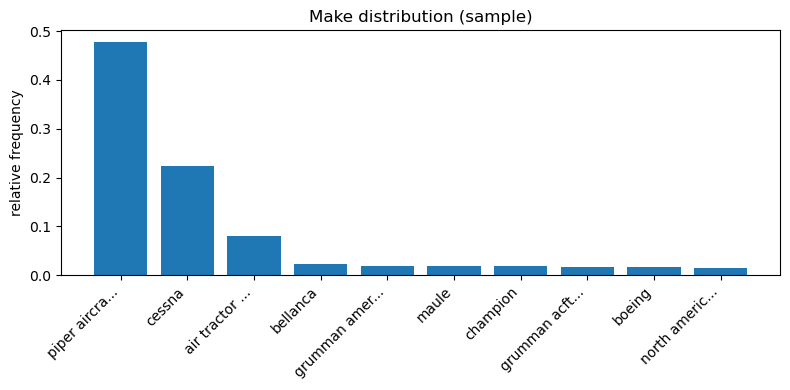

 Mapping saved in make_clusters_combined_optimized.csv


In [152]:
# Loading the datasets
df_ntsb = pd.read_pickle('data_sources/fused/aviation_accident_integrated.pkl')

# Building the Data Mart for modeling:
# - Selects the relevant variables from the NTSB dataset (engine_type)
# - Removes rows with missing or NA values
# - The result is a consistent and clean subset, usable for analysis

df_sample = df_ntsb[df_ntsb['engine_type'].notna() & (df_ntsb['engine_type'] != '')].copy()

# Cleaning and Normalization
def clean_text(s):
    return str(s).lower().strip()

df_ntsb['Vehicles.Make'] = df_ntsb['Vehicles.Make'].apply(clean_text)
df_sample['Vehicles.Make'] = df_sample['Vehicles.Make'].apply(clean_text)

# === 3. Union of Makes ===
all_makes = pd.concat([
    df_ntsb['Vehicles.Make'],
    df_sample['Vehicles.Make']
]).dropna().unique().tolist()

# === 4. Definition of "intelligent" tokenizer===
#   We remove the generic tokens of aeronautical companies:
STOPWORDS = {
    'aircraft', 'aircrafts', 'inc', 'inc.', 'corp', 'corp.',
    'company', 'company.', 'co', 'co.', 'ltd', 'ltd.', 'llc', 'srl',
    'gmbh', 'spol', 'sro', 'pty', 'spa', 'sas',
    'aerospace', 'aerospace.', 'aviation', 'aviation.', 'american'
}

def tokenize_clean(s):
    """
    Divide la stringa in parole, rimuove i token “stopwords”
    e restituisce l’insieme dei token rimanenti.
    """
    tokens = set(s.replace(',', ' ').split())  
    return {t for t in tokens if t not in STOPWORDS}

# === 5. Pre-calculation of tokens for each make ===
token_cache = {m: tokenize_clean(m) for m in all_makes}

# === 6. Combined clustering ===
make_clusters = {}
representatives = []

for make in all_makes:
    make_tokens = token_cache[make]
    matched = False

    for rep in representatives:
        rep_tokens = token_cache[rep]
        token_overlap = len(make_tokens & rep_tokens)
        similarity = distance.JaroWinkler.similarity(make, rep)

        # Hybrid policy:
        #   • two or more non-generic tokens in common
        #   • or similarity 0.8
        if token_overlap > 2 or similarity >= 0.85:
            make_clusters[make] = rep
            matched = True
            break

    if not matched:
        # If I have not found a compatible representative, I create a new one
        make_clusters[make] = make
        representatives.append(make)

# === 7. Mapping  ===
df_ntsb['Vehicles.Make'] = df_ntsb['Vehicles.Make'].map(make_clusters)
df_sample['Vehicles.Make'] = df_sample['Vehicles.Make'].map(make_clusters)

# === 8. Count Frequencies ===
freq_full = df_ntsb['Vehicles.Make'].value_counts()
freq_sample = df_sample['Vehicles.Make'].value_counts()

# === 9. Align Frequencies ===
common_makes = freq_full.index.intersection(freq_sample.index)
counts_sample = freq_sample[common_makes]
counts_full = freq_full[common_makes]

# === 10. Frequency Normalization ===
expected = counts_full / counts_full.sum() * counts_sample.sum()

# === 11. Test Chi-quadrato ===
chi2_stat, p_value = chisquare(f_obs=counts_sample, f_exp=expected)
print(f"Chi² statistic: {chi2_stat:.2f}")
print(f"p-value: {p_value:.4f}")

# === 12. Plot  ===
freq_sample_norm = freq_sample / freq_sample.sum()
top10 = freq_sample_norm.head(10)

# label shortening function
def shorten_label(label, max_len=12):
    return label if len(label) <= max_len else label[:max_len] + '...'


short_labels = [shorten_label(lbl) for lbl in top10.index]

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(short_labels, top10.values)
ax.set_title('Make distribution (sample)')
ax.set_ylabel('relative frequency')

ax.set_xticks(range(len(short_labels)))
ax.set_xticklabels(short_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()
# === 13. Save ===
mapping_df = pd.DataFrame(
    list(make_clusters.items()),
    columns=['original_make', 'standardized_make']
)
mapping_df.to_csv('data_sources/binding/make_clusters_combined_optimized.csv', index=False)
print(" Mapping saved in make_clusters_combined_optimized.csv")

• The Chi-squared test returned a p-value close to zero, indicating a statistically significant difference between the make distributions in the matched sample and the full NTSB dataset.
Therefore, the sample cannot be considered representative of the full dataset with respect to aircraft manufacturers.

## Distribution of Engine_Type in the sample

In [153]:
df_sample['engine_type'] = df_sample['engine_type'].astype('category')
freq_sample = df_sample['engine_type'].value_counts()

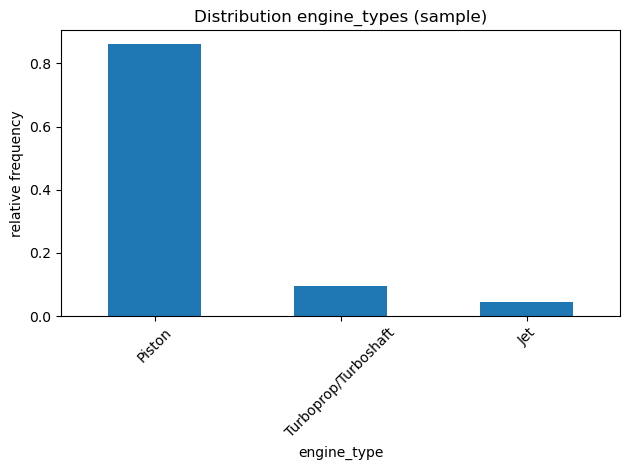

In [154]:
freq_sample_norm = freq_sample / freq_sample.sum()
freq_sample_norm.head(10).plot(kind='bar', title='Distribution engine_types (sample)', ylabel='relative frequency', rot=45)
plt.tight_layout()
plt.show()

• The bar plot shows that piston engines are by far the most common engine type among aircraft in the matched sample, accounting for over 85% of the total. Turboprop/Turboshaft and jet engines appear much less frequently, indicating that the majority of incidents in this subset involve general aviation aircraft rather than commercial jets or turbine-powered aircraft.

## Correlation between Flt and Monthly Accidents

In [155]:
# Loading the datasets
df_ntsb = pd.read_pickle('data_sources/fused/aviation_accident_integrated.pkl')
df = df_ntsb.copy()

Correlation between monthly average flights and number of incidents: 0.5662


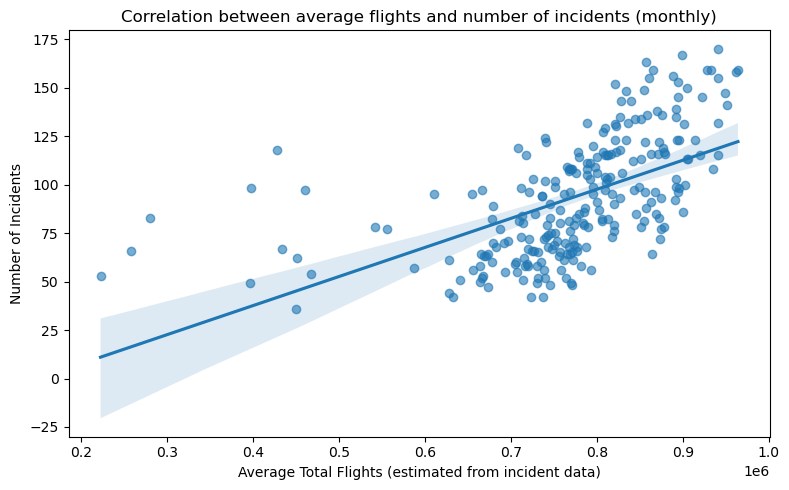

In [156]:
# 1. Parsing date and extracting year/month
df_ntsb['EventDate'] = pd.to_datetime(df_ntsb['EventDate'], errors='coerce')
df_ntsb['Year'] = df_ntsb['EventDate'].dt.year
df_ntsb['Month'] = df_ntsb['EventDate'].dt.month

# 2. # Building the Data Mart for modeling:
# - Selects the relevant variables from the NTSB dataset (TotalFlights)
# - Removes rows with missing or NA values
# - The result is a consistent and clean subset, usable for analysis
df_valid = df_ntsb[df_ntsb['TotalFlights'].notna()].copy()

#3. Group by year and month: Count incidents and calculate average monthly flights
df_monthly = df_valid.groupby(['Year', 'Month']).agg(
    Num_Incidents=('Oid', 'count'),
    Avg_Flights=('TotalFlights', 'mean')  # media dei voli mensili stimata dagli incidenti
).reset_index()

# 4. Calculate the correlation
correlation = df_monthly['Avg_Flights'].corr(df_monthly['Num_Incidents'])
print(f"Correlation between monthly average flights and number of incidents: {correlation:.4f}")

# 5. Plot

plt.figure(figsize=(8, 5))
sns.regplot(x='Avg_Flights', y='Num_Incidents', data=df_monthly, scatter_kws={'alpha': 0.6})
plt.title('Correlation between average flights and number of incidents (monthly)')
plt.xlabel('Average Total Flights (estimated from incident data)')
plt.ylabel('Number of Incidents')
plt.tight_layout()
plt.show()


• The correlation value of 0.56 highlights a weak relationship: as monthly flights increase, there is only a modest rise in accidents.

In [157]:
display(df)

,Vehicles.DamageLevel,Vehicles.ExplosionType,Vehicles.FireType,Vehicles.SerialNumber,Vehicles.Make,Vehicles.Model,Vehicles.NumberOfEngines,Vehicles.RegistrationNumber,Vehicles.FlightOperationType,Vehicles.OperatorName,...,wind_direction_10m,wind_direction_100m,wind_gusts_10m,weather_code,snow_depth,time_diff,engine_type,TotalPassengers,TotalFlights,LoadFactor
0,substantial,none,none,0702,cirrus design corp,sr22t,1,n773gb,pers,jkc llc,...,326.0,327.0,39.6,71.0,0.02,0 days 00:20:00,NaN,NaN,NaN,NaN
1,substantial,none,none,004ce,golden avio s r l,f30 brio,1,n37ga,pers,None,...,201.0,202.0,21.6,0.0,0.00,0 days 00:13:00,NaN,NaN,NaN,NaN
2,substantial,none,none,4692139,piper aircraft inc,pa46r 350t,1,n539ma,pers,rtm aviation llc,...,56.0,21.0,8.3,0.0,0.00,0 days 00:13:00,Piston,NaN,NaN,NaN
3,substantial,none,none,79-30941,bellanca,17 30a,1,n678mj,pers,piasa llc,...,256.0,256.0,24.5,0.0,0.02,0 days 00:00:00,NaN,NaN,NaN,NaN
4,substantial,none,none,7452c,maule,m 6 235,1,n71ms,aobv,taf aerial services llc,...,302.0,305.0,23.0,0.0,0.00,0 days 00:27:00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23398,substantial,none,none,18280322,cessna,182s,1,n2724r,inst,None,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,47938280.0,842827.0,66.0
23399,substantial,none,none,15071598,cessna,150k,1,n6098g,pers,None,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,47938280.0,842827.0,66.0
23400,destroyed,none,on-ground,aa1a-0126,grumman american,aa 1a,1,n9226l,pers,None,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,47938280.0,842827.0,66.0
23401,destroyed,none,none,20-0061,aircraft mfg dev co amd,ch2000,1,n8500r,inst,None,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,47938280.0,842827.0,66.0
